In [4]:
!pip3 install torch_geometric

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 391.1 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 191.5 kB/s eta 0:00:000:00:010:00:01:01
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: reportbug 11.4.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of reportbug or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release 

In [1]:
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm import tqdm
import scipy.sparse as sp
import gc

from torch.utils.data import TensorDataset as TensorDataset
from torch.utils.data import DataLoader as DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_path = "dataset and code /"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import json
with open(f"{base_path}user_stats.json", 'r') as f:
    user_stats = json.load(f)


user_features_df = pd.DataFrame.from_dict(user_stats, orient='index')

user_features_df = user_features_df.reset_index().rename(columns={'index': 'user_id'})


book_features_df = pd.read_csv(base_path + "books_data.csv").fillna(0)
book_features_df.drop(columns=['title', 'publication_year', 'ratings_count', 'text_reviews_count'], inplace=True, axis=1)


In [6]:
columns = ['user_id', 'book_id', 'rating']
ratings_df = pd.read_csv(base_path + "dataset.csv").fillna(0)
ratings_df.drop(columns=['review_text', 'n_votes'], inplace=True, axis=1)


In [7]:
ratings_df['rating'].value_counts()

4    1685130
5    1663722
3    1022358
0     282300
2     259330
1      80223
Name: rating, dtype: int64

In [8]:
train, test = train_test_split(ratings_df.values, test_size=0.1, random_state=42)
train_df = pd.DataFrame(train, columns=ratings_df.columns)
test_df = pd.DataFrame(test, columns=ratings_df.columns)

In [9]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['book_id_idx'] = le_item.fit_transform(train_df['book_id'].values)



In [10]:
train_df.head()

,user_id,book_id,rating,user_id_idx,book_id_idx
0,6c7fce68e0760e97de9aaad7617ca5f4,4952,4,82893,90
1,26ae186144f285359f7b18df10d4cb91,977817,5,29258,4998
2,70f2c46cacf5da27f17fea34b4684456,90952,4,86266,1024
3,0f52329fbd7afa66717148ba9dd4ac38,233719,3,11538,2073
4,15d01fa2fe4777d7965e9fe10ee2d1f8,2419450,1,16567,7207


In [11]:
train_user_ids = train_df['user_id'].unique()
train_book_ids = train_df['book_id'].unique()

user_features_df = user_features_df[user_features_df['user_id'].isin(train_user_ids)]
book_features_df = book_features_df[book_features_df['book_id'].isin(train_book_ids)]

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['book_id'].isin(train_book_ids))
]


In [12]:
user_features_df['user_id_idx'] = le_user.transform(user_features_df['user_id'].values)
book_features_df['book_id_idx'] = le_item.transform(book_features_df['book_id'].values)
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['book_id_idx'] = le_item.transform(test_df['book_id'].values)

In [13]:
n_users = train_df['user_id_idx'].nunique()
n_books = train_df['book_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Books : ", n_books)

Number of Unique Users :  195667
Number of unique Books :  31220


In [14]:
def rating_data_loader(data, batch_size):
    users = torch.LongTensor(data['user_id_idx'].values)
    items = torch.LongTensor(data['book_id_idx'].values)
    ratings = torch.FloatTensor(data['rating'].values.astype(np.float32))
    
    dataset = TensorDataset(users, items, ratings)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [15]:
u_t = torch.FloatTensor(train_df.user_id_idx)
b_t = torch.FloatTensor(train_df.book_id_idx) + n_users

train_edge_index = torch.stack((
    torch.cat([u_t, b_t]),
    torch.cat([b_t, u_t])
)).to(device)
train_edge_index = train_edge_index.type(torch.long)

In [16]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [17]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [18]:
class RatingPredictionGNN(nn.Module):
    def __init__(
            self,
            latent_dim,
            num_layers,
            num_users,
            num_books,
            model,
            user_features,
            book_numerical_features,
            book_genre_features,
            dropout=0.1
    ):
        super(RatingPredictionGNN, self).__init__()
        assert (model == 'NGCF' or model == 'LightGCN'), 'Model must be NGCF or LightGCN'
        self.model = model

        # Keep the same feature processing and embedding parts
        self.user_features = user_features
        self.book_numerical_features = book_numerical_features
        self.book_genre_features = book_genre_features

        self.user_feature_proj = nn.Linear(user_features.shape[1], latent_dim)
        self.book_numerical_features_proj = nn.Linear(book_numerical_features.shape[1], latent_dim)
        self.book_genre_features_proj = nn.Linear(book_genre_features.shape[1], latent_dim)

        self.embedding = nn.Embedding(num_users + num_books, latent_dim)

        if self.model == 'NGCF':
            self.convs = nn.ModuleList(
                NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
            )
        else:
            self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        # Add prediction layers for ratings
        self.prediction = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(latent_dim, 1)
        )

        self.init_parameters()
    
    def init_parameters(self):
        if self.model == 'NGCF':
            nn.init.xavier_uniform_(self.embedding.weight, gain=1)
            nn.init.xavier_uniform_(self.user_feature_proj.weight)
            nn.init.xavier_uniform_(self.book_numerical_features_proj.weight)
            nn.init.xavier_uniform_(self.book_genre_features_proj.weight)
        else:
            nn.init.normal_(self.embedding.weight, std=0.1)
            nn.init.normal_(self.user_feature_proj.weight, std=0.1)
            nn.init.normal_(self.book_numerical_features_proj.weight, std=0.1)
            nn.init.normal_(self.book_genre_features_proj.weight, std=0.1)
            
    def forward(self, edge_index):
        # Same as before until obtaining embeddings
        user_proj = self.user_feature_proj(self.user_features)
        book_num_proj = self.book_numerical_features_proj(self.book_numerical_features)
        book_genre_proj = self.book_genre_features_proj(self.book_genre_features)

        book_proj = book_num_proj + book_genre_proj

        emb0 = self.embedding.weight.clone()
        emb0[:self.user_features.shape[0]] += user_proj
        emb0[self.user_features.shape[0]:] += book_proj

        embs = [emb0]
        emb = emb0

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = (
            torch.cat(embs, dim=-1) if self.model == 'NGCF'
            else torch.mean(torch.stack(embs, dim=0), dim=0)
        )

        return emb0, out

    def predict_ratings(self, user_indices, item_indices, final_embeddings):
        """Predict ratings for given user-item pairs"""
        user_emb = final_embeddings[user_indices]
        item_emb = final_embeddings[item_indices]
        
        # Concatenate user and item embeddings
        combined = torch.cat([user_emb, item_emb], dim=1)
        
        # Predict rating
        rating = self.prediction(combined)
        return rating.squeeze()

In [19]:
def train_rating_prediction(model, optimizer, train_df, test_df, train_edge_index, num_epochs=50, batch_size=1024):
    model.train()
    n_users = len(train_df['user_id_idx'].unique())
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        # Create batches of user-item pairs and ratings
       
        dataloader = rating_data_loader(train_df, batch_size)
        
        for batch_users, batch_items, batch_ratings in dataloader:
            batch_users = batch_users.to(device)
            batch_items = batch_items.to(device)
            batch_ratings = batch_ratings.to(device)
            
            optimizer.zero_grad()
            
            # Get embeddings
            _, final_embeddings = model(train_edge_index)
            
            # Predict ratings
            predicted_ratings = model.predict_ratings(
                batch_users, 
                batch_items - n_users,  # Adjust item indices
                final_embeddings
            )
            
            # Calculate loss
            loss = F.mse_loss(predicted_ratings, batch_ratings)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Evaluation on test set
        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                _, final_embeddings = model(train_edge_index)
                test_users = torch.LongTensor(test_df['user_id_idx'].values).to(device)
                test_items = torch.LongTensor(test_df['book_id_idx'].values).to(device)
                test_ratings = torch.FloatTensor(test_df['rating'].values).to(device)
                
                predicted_test_ratings = model.predict_ratings(
                    test_users,
                    test_items,
                    final_embeddings
                )
                
                test_rmse = torch.sqrt(F.mse_loss(predicted_test_ratings, test_ratings))
                test_mae = F.l1_loss(predicted_test_ratings, test_ratings)
                
                print(f"Epoch {epoch + 1}:")
                print(f"Train Loss: {total_loss/len(dataloader):.4f}")
                print(f"Test RMSE: {test_rmse:.4f}")
                print(f"Test MAE: {test_mae:.4f}")
            model.train()

In [20]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.001
K = 20

In [21]:
user_feature_cols =['mean', 'variance']
book_numerical_cols = ['num_pages', 'average_rating', 'rating_variance']
genre_cols = ['Children', 'Biography', 'Comics', 'Fantasy Paranormal',
              'Mystery Thriller Crime', 'Poetry', 'Young Adult', 'Romance']
user_features = torch.FloatTensor(
    user_features_df[user_feature_cols].values
).to(device)

book_numerical_features = torch.FloatTensor(
    book_features_df[book_numerical_cols].values
).to(device)

book_genre_features = torch.FloatTensor(
    book_features_df[genre_cols].values
).to(device)

In [22]:
class RatingTrainer:
    def __init__(
        self,
        model,
        train_df,
        test_df,
        edge_index,
        n_users,
        device,
        batch_size=1024,
        lr=0.001,
        weight_decay=1e-4
    ):
        self.model = model
        self.train_df = train_df
        self.test_df = test_df
        self.edge_index = edge_index
        self.n_users = n_users
        self.device = device
        self.batch_size = batch_size
        
        # Create data loaders
        self.train_loader = self._create_data_loader(train_df)
        self.test_loader = self._create_data_loader(test_df)
        
        # Initialize optimizer and scheduler
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=lr, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            patience=5, 
            factor=0.5, 
            verbose=True
        )
        
        # Keep track of best model
        self.best_rmse = float('inf')
        self.best_state_dict = None
        
    def _create_data_loader(self, df):
        user_tensor = torch.LongTensor(df['user_id_idx'].values)
        item_tensor = torch.LongTensor(df['book_id_idx'].values)
        ratings = torch.FloatTensor(df['rating'].values.astype(np.float32))
        
        dataset = TensorDataset(user_tensor, item_tensor, ratings)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
    
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        
        for batch_users, batch_items, batch_ratings in tqdm(self.train_loader, desc="Training"):
            batch_users = batch_users.to(self.device)
            batch_items = batch_items.to(self.device)
            batch_ratings = batch_ratings.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Get embeddings
            _, final_embeddings = self.model(self.edge_index)
            
            # Predict ratings
            predicted_ratings = self.model.predict_ratings(
                batch_users,
                batch_items,
                final_embeddings
            )
            
            # Calculate loss
            loss = torch.nn.functional.mse_loss(predicted_ratings, batch_ratings)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    @torch.no_grad()
    def evaluate(self):
        self.model.eval()
        predictions = []
        actuals = []
        
        for batch_users, batch_items, batch_ratings in tqdm(self.test_loader, desc="Evaluating"):
            batch_users = batch_users.to(self.device)
            batch_items = batch_items.to(self.device)
            
            _, final_embeddings = self.model(self.edge_index)
            pred_ratings = self.model.predict_ratings(
                batch_users,
                batch_items,
                final_embeddings
            )
            
            predictions.extend(pred_ratings.cpu().numpy())
            actuals.extend(batch_ratings.numpy())
        
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        
        return rmse, mae
    
    def train(self, num_epochs=50, early_stopping_patience=10):
        no_improve = 0
        
        for epoch in range(num_epochs):
            # Train
            train_loss = self.train_epoch()
            
            # Evaluate
            test_rmse, test_mae = self.evaluate()
            
            # Learning rate scheduling
            self.scheduler.step(test_rmse)
            
            # Save best model
            if test_rmse < self.best_rmse:
                self.best_rmse = test_rmse
                self.best_state_dict = self.model.state_dict()
                no_improve = 0
            else:
                no_improve += 1
            
            print(f"Epoch {epoch + 1}:")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Test RMSE: {test_rmse:.4f}")
            print(f"Test MAE: {test_mae:.4f}")
            print("-" * 50)
            
            # Early stopping
            if no_improve >= early_stopping_patience:
                print("Early stopping triggered!")
                break
        
        # Load best model
        self.model.load_state_dict(self.best_state_dict)
        return self.model

class RatingInference:
    def __init__(self, model, edge_index, n_users, device):
        self.model = model
        self.edge_index = edge_index
        self.n_users = n_users
        self.device = device
        
        # Compute embeddings once
        self.model.eval()
        with torch.no_grad():
            _, self.final_embeddings = self.model(self.edge_index)
    
    @torch.no_grad()
    def predict_single_rating(self, user_idx, item_idx):
        """Predict rating for a single user-item pair"""
        user_tensor = torch.LongTensor([user_idx]).to(self.device)
        item_tensor = torch.LongTensor([item_idx]).to(self.device)
        
        pred_rating = self.model.predict_ratings(
            user_tensor,
            item_tensor,
            self.final_embeddings
        )
        
        return pred_rating.item()
    
    @torch.no_grad()
    def predict_top_k_items(self, user_idx, k=10, exclude_rated=True, rated_items=None):
        """Predict top K items for a user"""
        user_tensor = torch.LongTensor([user_idx]).to(self.device)
        
        # Predict ratings for all items
        all_items = torch.arange(self.n_users).to(self.device)
        pred_ratings = self.model.predict_ratings(
            user_tensor.repeat(len(all_items)),
            all_items,
            self.final_embeddings
        )
        
        # Exclude already rated items if requested
        if exclude_rated and rated_items is not None:
            pred_ratings[rated_items] = float('-inf')
        
        # Get top K items
        top_k_ratings, top_k_indices = torch.topk(pred_ratings, k)
        
        return top_k_indices.cpu().numpy(), top_k_ratings.cpu().numpy()


In [23]:
model = RatingPredictionGNN(
        latent_dim=64,
        num_layers=3,
        num_users=n_users,
        num_books=n_books,
        model='LightGCN',
        user_features=user_features,
        book_numerical_features=book_numerical_features,
        book_genre_features=book_genre_features
    ).to(device)
    
    # Create trainer
trainer = RatingTrainer(
    model=model,
    train_df=train_df,
    test_df=test_df,
    edge_index=train_edge_index,
    n_users=n_users,
    device=device,
    batch_size=1024,
    lr=0.001
)

# Train model
trained_model = trainer.train(num_epochs=50)

/home/howard/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:35<00:00, 13.71it/s]


Epoch 1:
Train Loss: 1.5177
Test RMSE: 1.1677
Test MAE: 0.9094
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.24it/s]


Epoch 2:
Train Loss: 1.3689
Test RMSE: 1.1593
Test MAE: 0.8618
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.24it/s]


Epoch 3:
Train Loss: 1.3392
Test RMSE: 1.1624
Test MAE: 0.9001
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.25it/s]


Epoch 4:
Train Loss: 1.3189
Test RMSE: 1.1422
Test MAE: 0.8684
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 5:
Train Loss: 1.3088
Test RMSE: 1.1299
Test MAE: 0.8272
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.26it/s]


Epoch 6:
Train Loss: 1.3043
Test RMSE: 1.1310
Test MAE: 0.8284
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.25it/s]


Epoch 7:
Train Loss: 1.3009
Test RMSE: 1.1331
Test MAE: 0.8315
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 8:
Train Loss: 1.3008
Test RMSE: 1.1284
Test MAE: 0.8270
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 9:
Train Loss: 1.2994
Test RMSE: 1.1276
Test MAE: 0.8302
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.28it/s]


Epoch 10:
Train Loss: 1.2985
Test RMSE: 1.1367
Test MAE: 0.8564
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 11:
Train Loss: 1.2995
Test RMSE: 1.1300
Test MAE: 0.8423
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.33it/s]


Epoch 12:
Train Loss: 1.2987
Test RMSE: 1.1281
Test MAE: 0.8308
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.25it/s]


Epoch 13:
Train Loss: 1.2991
Test RMSE: 1.1333
Test MAE: 0.8238
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.28it/s]


Epoch 14:
Train Loss: 1.2961
Test RMSE: 1.1295
Test MAE: 0.8464
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.28it/s]


Epoch 15:
Train Loss: 1.2963
Test RMSE: 1.1291
Test MAE: 0.8362
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.33it/s]


Epoch 16:
Train Loss: 1.2840
Test RMSE: 1.1265
Test MAE: 0.8192
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.28it/s]


Epoch 17:
Train Loss: 1.2814
Test RMSE: 1.1262
Test MAE: 0.8366
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 18:
Train Loss: 1.2821
Test RMSE: 1.1296
Test MAE: 0.8244
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 19:
Train Loss: 1.2822
Test RMSE: 1.1235
Test MAE: 0.8277
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.28it/s]


Epoch 20:
Train Loss: 1.2822
Test RMSE: 1.1323
Test MAE: 0.8214
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 21:
Train Loss: 1.2822
Test RMSE: 1.1256
Test MAE: 0.8328
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.31it/s]


Epoch 22:
Train Loss: 1.2809
Test RMSE: 1.1235
Test MAE: 0.8285
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.33it/s]


Epoch 23:
Train Loss: 1.2824
Test RMSE: 1.1337
Test MAE: 0.8240
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.28it/s]


Epoch 24:
Train Loss: 1.2820
Test RMSE: 1.1367
Test MAE: 0.8613
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.25it/s]


Epoch 25:
Train Loss: 1.2811
Test RMSE: 1.1240
Test MAE: 0.8246
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.24it/s]


Epoch 26:
Train Loss: 1.2745
Test RMSE: 1.1276
Test MAE: 0.8457
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.25it/s]


Epoch 27:
Train Loss: 1.2721
Test RMSE: 1.1255
Test MAE: 0.8420
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 28:
Train Loss: 1.2717
Test RMSE: 1.1219
Test MAE: 0.8212
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 29:
Train Loss: 1.2715
Test RMSE: 1.1216
Test MAE: 0.8212
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 30:
Train Loss: 1.2713
Test RMSE: 1.1208
Test MAE: 0.8231
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 31:
Train Loss: 1.2711
Test RMSE: 1.1232
Test MAE: 0.8189
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.26it/s]


Epoch 32:
Train Loss: 1.2711
Test RMSE: 1.1220
Test MAE: 0.8222
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 33:
Train Loss: 1.2706
Test RMSE: 1.1228
Test MAE: 0.8316
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 34:
Train Loss: 1.2707
Test RMSE: 1.1224
Test MAE: 0.8341
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 35:
Train Loss: 1.2698
Test RMSE: 1.1223
Test MAE: 0.8303
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.23it/s]


Epoch 36:
Train Loss: 1.2708
Test RMSE: 1.1219
Test MAE: 0.8315
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.25it/s]


Epoch 37:
Train Loss: 1.2666
Test RMSE: 1.1207
Test MAE: 0.8285
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 38:
Train Loss: 1.2656
Test RMSE: 1.1206
Test MAE: 0.8154
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.26it/s]


Epoch 39:
Train Loss: 1.2649
Test RMSE: 1.1200
Test MAE: 0.8226
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 40:
Train Loss: 1.2648
Test RMSE: 1.1202
Test MAE: 0.8236
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 41:
Train Loss: 1.2645
Test RMSE: 1.1193
Test MAE: 0.8240
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.20it/s]


Epoch 42:
Train Loss: 1.2649
Test RMSE: 1.1197
Test MAE: 0.8205
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 43:
Train Loss: 1.2644
Test RMSE: 1.1213
Test MAE: 0.8318
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.27it/s]


Epoch 44:
Train Loss: 1.2641
Test RMSE: 1.1193
Test MAE: 0.8216
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.26it/s]


Epoch 45:
Train Loss: 1.2644
Test RMSE: 1.1225
Test MAE: 0.8321
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.29it/s]


Epoch 46:
Train Loss: 1.2641
Test RMSE: 1.1208
Test MAE: 0.8243
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.22it/s]


Epoch 47:
Train Loss: 1.2640
Test RMSE: 1.1210
Test MAE: 0.8173
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.25it/s]


Epoch 48:
Train Loss: 1.2618
Test RMSE: 1.1193
Test MAE: 0.8191
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:32<00:00, 15.25it/s]


Epoch 49:
Train Loss: 1.2607
Test RMSE: 1.1186
Test MAE: 0.8230
--------------------------------------------------


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████| 488/488 [00:31<00:00, 15.25it/s]

Epoch 50:
Train Loss: 1.2603
Test RMSE: 1.1185
Test MAE: 0.8210
--------------------------------------------------


In [24]:
print(model)

RatingPredictionGNN(
  (user_feature_proj): Linear(in_features=2, out_features=64, bias=True)
  (book_numerical_features_proj): Linear(in_features=3, out_features=64, bias=True)
  (book_genre_features_proj): Linear(in_features=8, out_features=64, bias=True)
  (embedding): Embedding(226520, 64)
  (convs): ModuleList(
    (0-2): 3 x LightGCNConv()
  )
  (prediction): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


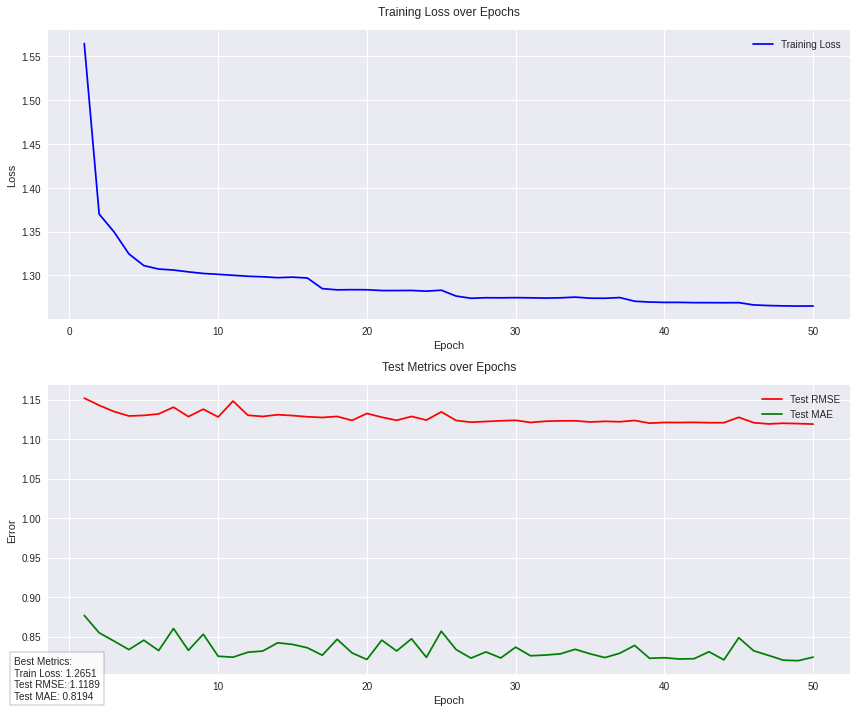

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from the log
epochs = list(range(1, 51))
train_loss = [1.5645, 1.3700, 1.3497, 1.3246, 1.3113, 1.3073, 1.3062, 1.3041, 1.3023, 1.3013,
              1.3002, 1.2991, 1.2985, 1.2975, 1.2981, 1.2971, 1.2850, 1.2836, 1.2838, 1.2837,
              1.2828, 1.2828, 1.2829, 1.2821, 1.2832, 1.2765, 1.2740, 1.2746, 1.2745, 1.2747,
              1.2745, 1.2742, 1.2745, 1.2753, 1.2741, 1.2740, 1.2748, 1.2706, 1.2697, 1.2693,
              1.2693, 1.2690, 1.2690, 1.2689, 1.2690, 1.2664, 1.2657, 1.2653, 1.2651, 1.2652]

test_rmse = [1.1518, 1.1427, 1.1348, 1.1292, 1.1299, 1.1318, 1.1403, 1.1284, 1.1378, 1.1279,
             1.1481, 1.1301, 1.1286, 1.1308, 1.1297, 1.1282, 1.1273, 1.1286, 1.1236, 1.1324,
             1.1276, 1.1237, 1.1286, 1.1240, 1.1344, 1.1235, 1.1213, 1.1222, 1.1231, 1.1237,
             1.1210, 1.1225, 1.1230, 1.1231, 1.1216, 1.1224, 1.1219, 1.1235, 1.1201, 1.1210,
             1.1209, 1.1211, 1.1207, 1.1207, 1.1275, 1.1207, 1.1191, 1.1200, 1.1195, 1.1189]

test_mae = [0.8767, 0.8547, 0.8442, 0.8334, 0.8453, 0.8322, 0.8601, 0.8325, 0.8529, 0.8250,
            0.8238, 0.8301, 0.8316, 0.8420, 0.8400, 0.8357, 0.8263, 0.8465, 0.8292, 0.8209,
            0.8454, 0.8317, 0.8471, 0.8236, 0.8567, 0.8334, 0.8226, 0.8305, 0.8228, 0.8365,
            0.8256, 0.8265, 0.8280, 0.8338, 0.8281, 0.8233, 0.8288, 0.8387, 0.8224, 0.8231,
            0.8215, 0.8219, 0.8307, 0.8204, 0.8485, 0.8319, 0.8261, 0.8200, 0.8194, 0.8239]

# Create figure with subplots
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot training loss
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.set_title('Training Loss over Epochs', pad=15)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# Plot test metrics
ax2.plot(epochs, test_rmse, 'r-', label='Test RMSE')
ax2.plot(epochs, test_mae, 'g-', label='Test MAE')
ax2.set_title('Test Metrics over Epochs', pad=15)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Error')
ax2.grid(True)
ax2.legend()

# Add summary statistics
min_train_loss = min(train_loss)
min_test_rmse = min(test_rmse)
min_test_mae = min(test_mae)

text = f'Best Metrics:\nTrain Loss: {min_train_loss:.4f}\nTest RMSE: {min_test_rmse:.4f}\nTest MAE: {min_test_mae:.4f}'
plt.figtext(0.02, 0.02, text, ha='left', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('performance-dim32.png')
plt.show()

In [59]:
torch.cuda.empty_cache()

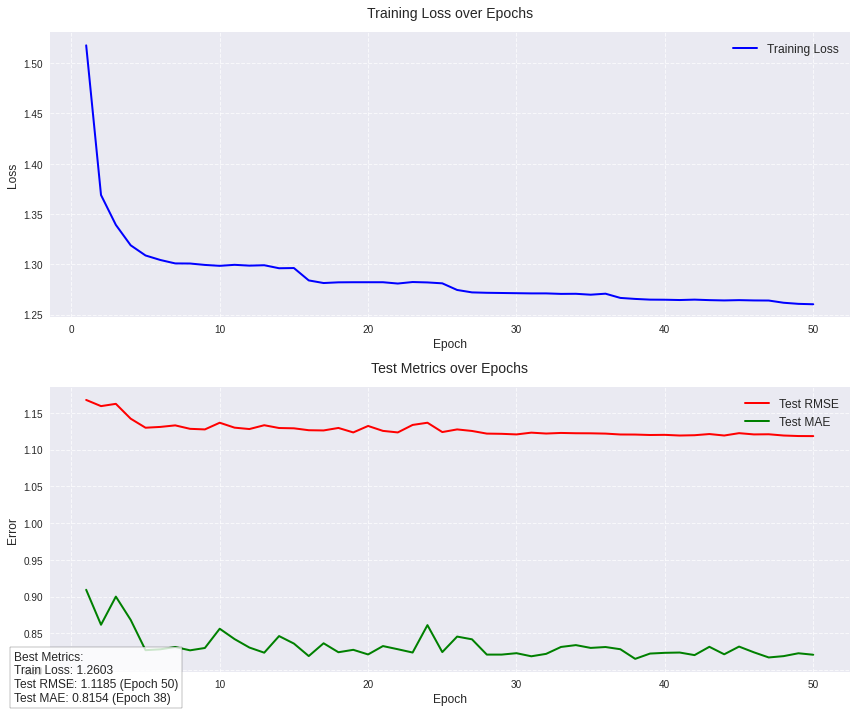


Training Analysis:
Initial Train Loss: 1.5177
Final Train Loss: 1.2603
Loss Improvement: 16.96%

Best Test RMSE: 1.1185 at Epoch 50
Best Test MAE: 0.8154 at Epoch 38


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from the log
epochs = list(range(1, 51))
train_loss = [1.5177, 1.3689, 1.3392, 1.3189, 1.3088, 1.3043, 1.3009, 1.3008, 1.2994, 1.2985,
              1.2995, 1.2987, 1.2991, 1.2961, 1.2963, 1.2840, 1.2814, 1.2821, 1.2822, 1.2822,
              1.2822, 1.2809, 1.2824, 1.2820, 1.2811, 1.2745, 1.2721, 1.2717, 1.2715, 1.2713,
              1.2711, 1.2711, 1.2706, 1.2707, 1.2698, 1.2708, 1.2666, 1.2656, 1.2649, 1.2648,
              1.2645, 1.2649, 1.2644, 1.2641, 1.2644, 1.2641, 1.2640, 1.2618, 1.2607, 1.2603]

test_rmse = [1.1677, 1.1593, 1.1624, 1.1422, 1.1299, 1.1310, 1.1331, 1.1284, 1.1276, 1.1367,
             1.1300, 1.1281, 1.1333, 1.1295, 1.1291, 1.1265, 1.1262, 1.1296, 1.1235, 1.1323,
             1.1256, 1.1235, 1.1337, 1.1367, 1.1240, 1.1276, 1.1255, 1.1219, 1.1216, 1.1208,
             1.1232, 1.1220, 1.1228, 1.1224, 1.1223, 1.1219, 1.1207, 1.1206, 1.1200, 1.1202,
             1.1193, 1.1197, 1.1213, 1.1193, 1.1225, 1.1208, 1.1210, 1.1193, 1.1186, 1.1185]

test_mae = [0.9094, 0.8618, 0.9001, 0.8684, 0.8272, 0.8284, 0.8315, 0.8270, 0.8302, 0.8564,
            0.8423, 0.8308, 0.8238, 0.8464, 0.8362, 0.8192, 0.8366, 0.8244, 0.8277, 0.8214,
            0.8328, 0.8285, 0.8240, 0.8613, 0.8246, 0.8457, 0.8420, 0.8212, 0.8212, 0.8231,
            0.8189, 0.8222, 0.8316, 0.8341, 0.8303, 0.8315, 0.8285, 0.8154, 0.8226, 0.8236,
            0.8240, 0.8205, 0.8318, 0.8216, 0.8321, 0.8243, 0.8173, 0.8191, 0.8230, 0.8210]

# Set style
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot training loss
ax1.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
ax1.set_title('Training Loss over Epochs', fontsize=14, pad=15)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=12)

# Plot test metrics
ax2.plot(epochs, test_rmse, 'r-', label='Test RMSE', linewidth=2)
ax2.plot(epochs, test_mae, 'g-', label='Test MAE', linewidth=2)
ax2.set_title('Test Metrics over Epochs', fontsize=14, pad=15)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Error', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=12)

# Add summary statistics
min_train_loss = min(train_loss)
min_test_rmse = min(test_rmse)
min_test_mae = min(test_mae)

best_epoch_rmse = epochs[test_rmse.index(min_test_rmse)]
best_epoch_mae = epochs[test_mae.index(min_test_mae)]

stats_text = (
    f'Best Metrics:\n'
    f'Train Loss: {min_train_loss:.4f}\n'
    f'Test RMSE: {min_test_rmse:.4f} (Epoch {best_epoch_rmse})\n'
    f'Test MAE: {min_test_mae:.4f} (Epoch {best_epoch_mae})'
)

plt.figtext(0.02, 0.02, stats_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout and display
plt.tight_layout()
plt.savefig('performance-dim64.png')
plt.show()

# Print analysis
print("\nTraining Analysis:")
print(f"Initial Train Loss: {train_loss[0]:.4f}")
print(f"Final Train Loss: {train_loss[-1]:.4f}")
print(f"Loss Improvement: {((train_loss[0] - train_loss[-1]) / train_loss[0] * 100):.2f}%")
print(f"\nBest Test RMSE: {min_test_rmse:.4f} at Epoch {best_epoch_rmse}")
print(f"Best Test MAE: {min_test_mae:.4f} at Epoch {best_epoch_mae}")